In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.8 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.notebook import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
from imageio import imsave

In [14]:
from scipy.misc import imsave

ImportError: cannot import name 'imsave' from 'scipy.misc' (/home/clim-lab/miniconda3/envs/jiwon/lib/python3.7/site-packages/scipy/misc/__init__.py)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


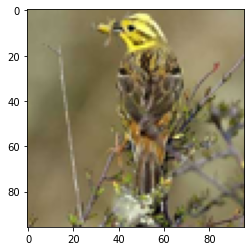

(5000, 96, 96, 3)
(5000,)
Saving images to disk
./img/2/0


NameError: name 'imsave' is not defined

In [10]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

# try:
#     from imageio import imsave
# except:
#     from scipy.misc import imsave

#tq V100에선 멀쩡히 됏는데 와이러노 ㅡㅡ

from imageio import imread
    
print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1
    
if __name__ == "__main__":
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)

In [15]:
def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

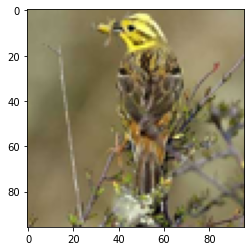

(5000, 96, 96, 3)
(5000,)
Saving images to disk
./img/2/0
./img/6/1
./img/2/2
./img/7/3
./img/4/4
./img/10/5
./img/8/6
./img/5/7
./img/6/8
./img/9/9
./img/1/10
./img/7/11
./img/1/12
./img/9/13
./img/8/14
./img/7/15
./img/5/16
./img/7/17
./img/3/18
./img/3/19
./img/2/20
./img/2/21
./img/7/22
./img/3/23
./img/2/24
./img/9/25
./img/6/26
./img/2/27
./img/6/28
./img/6/29
./img/1/30
./img/1/31
./img/1/32
./img/2/33
./img/4/34
./img/7/35
./img/8/36
./img/3/37
./img/2/38
./img/4/39
./img/2/40
./img/7/41
./img/2/42
./img/4/43
./img/8/44
./img/5/45
./img/4/46
./img/1/47
./img/7/48
./img/8/49
./img/7/50
./img/6/51
./img/9/52
./img/1/53
./img/7/54
./img/2/55
./img/4/56
./img/7/57
./img/9/58
./img/3/59
./img/3/60
./img/10/61
./img/10/62
./img/6/63
./img/2/64
./img/8/65
./img/9/66
./img/8/67
./img/9/68
./img/9/69
./img/10/70
./img/1/71
./img/6/72
./img/1/73
./img/3/74
./img/6/75
./img/6/76
./img/8/77
./img/9/78
./img/10/79
./img/6/80
./img/1/81
./img/9/82
./img/4/83
./img/3/84
./img/10/85
./img/7/86

./img/2/696
./img/2/697
./img/8/698
./img/5/699
./img/10/700
./img/7/701
./img/8/702
./img/5/703
./img/10/704
./img/10/705
./img/3/706
./img/8/707
./img/1/708
./img/6/709
./img/5/710
./img/1/711
./img/3/712
./img/8/713
./img/10/714
./img/6/715
./img/5/716
./img/5/717
./img/9/718
./img/1/719
./img/6/720
./img/7/721
./img/5/722
./img/9/723
./img/2/724
./img/3/725
./img/1/726
./img/10/727
./img/4/728
./img/2/729
./img/1/730
./img/9/731
./img/3/732
./img/1/733
./img/8/734
./img/5/735
./img/1/736
./img/5/737
./img/7/738
./img/4/739
./img/1/740
./img/4/741
./img/5/742
./img/7/743
./img/1/744
./img/8/745
./img/6/746
./img/6/747
./img/1/748
./img/6/749
./img/3/750
./img/9/751
./img/7/752
./img/2/753
./img/9/754
./img/6/755
./img/8/756
./img/4/757
./img/2/758
./img/4/759
./img/10/760
./img/7/761
./img/2/762
./img/8/763
./img/8/764
./img/5/765
./img/2/766
./img/3/767
./img/1/768
./img/8/769
./img/3/770
./img/8/771
./img/3/772
./img/8/773
./img/8/774
./img/6/775
./img/2/776
./img/4/777
./img/10/7

./img/8/1349
./img/2/1350
./img/9/1351
./img/6/1352
./img/2/1353
./img/2/1354
./img/4/1355
./img/8/1356
./img/4/1357
./img/2/1358
./img/2/1359
./img/6/1360
./img/9/1361
./img/7/1362
./img/9/1363
./img/4/1364
./img/8/1365
./img/5/1366
./img/7/1367
./img/9/1368
./img/4/1369
./img/6/1370
./img/3/1371
./img/5/1372
./img/10/1373
./img/4/1374
./img/6/1375
./img/7/1376
./img/7/1377
./img/9/1378
./img/10/1379
./img/6/1380
./img/5/1381
./img/1/1382
./img/10/1383
./img/5/1384
./img/1/1385
./img/6/1386
./img/5/1387
./img/8/1388
./img/6/1389
./img/5/1390
./img/2/1391
./img/6/1392
./img/8/1393
./img/8/1394
./img/5/1395
./img/6/1396
./img/8/1397
./img/7/1398
./img/3/1399
./img/3/1400
./img/6/1401
./img/7/1402
./img/1/1403
./img/10/1404
./img/5/1405
./img/6/1406
./img/1/1407
./img/6/1408
./img/7/1409
./img/6/1410
./img/1/1411
./img/1/1412
./img/8/1413
./img/5/1414
./img/6/1415
./img/9/1416
./img/7/1417
./img/7/1418
./img/3/1419
./img/2/1420
./img/6/1421
./img/5/1422
./img/9/1423
./img/8/1424
./img/7/

./img/5/2039
./img/1/2040
./img/3/2041
./img/4/2042
./img/3/2043
./img/9/2044
./img/8/2045
./img/5/2046
./img/1/2047
./img/3/2048
./img/3/2049
./img/2/2050
./img/3/2051
./img/3/2052
./img/4/2053
./img/1/2054
./img/4/2055
./img/1/2056
./img/7/2057
./img/6/2058
./img/10/2059
./img/5/2060
./img/10/2061
./img/6/2062
./img/8/2063
./img/5/2064
./img/6/2065
./img/2/2066
./img/6/2067
./img/3/2068
./img/9/2069
./img/10/2070
./img/1/2071
./img/5/2072
./img/4/2073
./img/3/2074
./img/5/2075
./img/1/2076
./img/3/2077
./img/9/2078
./img/1/2079
./img/10/2080
./img/9/2081
./img/8/2082
./img/7/2083
./img/10/2084
./img/3/2085
./img/10/2086
./img/3/2087
./img/7/2088
./img/8/2089
./img/9/2090
./img/8/2091
./img/7/2092
./img/10/2093
./img/1/2094
./img/4/2095
./img/5/2096
./img/10/2097
./img/5/2098
./img/10/2099
./img/1/2100
./img/1/2101
./img/4/2102
./img/4/2103
./img/7/2104
./img/6/2105
./img/3/2106
./img/10/2107
./img/5/2108
./img/6/2109
./img/3/2110
./img/6/2111
./img/6/2112
./img/1/2113
./img/5/2114
./

./img/8/2711
./img/8/2712
./img/9/2713
./img/4/2714
./img/10/2715
./img/7/2716
./img/4/2717
./img/8/2718
./img/1/2719
./img/8/2720
./img/4/2721
./img/10/2722
./img/1/2723
./img/10/2724
./img/8/2725
./img/4/2726
./img/3/2727
./img/6/2728
./img/2/2729
./img/7/2730
./img/2/2731
./img/6/2732
./img/7/2733
./img/5/2734
./img/2/2735
./img/2/2736
./img/5/2737
./img/10/2738
./img/2/2739
./img/5/2740
./img/1/2741
./img/9/2742
./img/2/2743
./img/8/2744
./img/3/2745
./img/9/2746
./img/8/2747
./img/8/2748
./img/7/2749
./img/6/2750
./img/6/2751
./img/3/2752
./img/6/2753
./img/7/2754
./img/1/2755
./img/7/2756
./img/4/2757
./img/5/2758
./img/3/2759
./img/3/2760
./img/3/2761
./img/2/2762
./img/7/2763
./img/3/2764
./img/5/2765
./img/4/2766
./img/7/2767
./img/4/2768
./img/10/2769
./img/5/2770
./img/6/2771
./img/3/2772
./img/2/2773
./img/6/2774
./img/10/2775
./img/8/2776
./img/10/2777
./img/10/2778
./img/5/2779
./img/5/2780
./img/1/2781
./img/5/2782
./img/10/2783
./img/3/2784
./img/7/2785
./img/8/2786
./i

./img/6/3350
./img/10/3351
./img/2/3352
./img/9/3353
./img/5/3354
./img/7/3355
./img/1/3356
./img/7/3357
./img/2/3358
./img/2/3359
./img/10/3360
./img/9/3361
./img/7/3362
./img/2/3363
./img/7/3364
./img/1/3365
./img/8/3366
./img/7/3367
./img/3/3368
./img/7/3369
./img/6/3370
./img/3/3371
./img/3/3372
./img/1/3373
./img/5/3374
./img/2/3375
./img/5/3376
./img/3/3377
./img/1/3378
./img/10/3379
./img/5/3380
./img/3/3381
./img/8/3382
./img/3/3383
./img/10/3384
./img/8/3385
./img/2/3386
./img/3/3387
./img/7/3388
./img/9/3389
./img/5/3390
./img/8/3391
./img/8/3392
./img/8/3393
./img/8/3394
./img/1/3395
./img/2/3396
./img/9/3397
./img/10/3398
./img/9/3399
./img/9/3400
./img/9/3401
./img/6/3402
./img/4/3403
./img/2/3404
./img/8/3405
./img/5/3406
./img/7/3407
./img/7/3408
./img/4/3409
./img/9/3410
./img/5/3411
./img/4/3412
./img/1/3413
./img/6/3414
./img/2/3415
./img/4/3416
./img/10/3417
./img/9/3418
./img/7/3419
./img/7/3420
./img/3/3421
./img/5/3422
./img/8/3423
./img/1/3424
./img/8/3425
./img/

./img/10/4004
./img/8/4005
./img/10/4006
./img/2/4007
./img/10/4008
./img/5/4009
./img/3/4010
./img/7/4011
./img/2/4012
./img/1/4013
./img/9/4014
./img/3/4015
./img/2/4016
./img/3/4017
./img/6/4018
./img/7/4019
./img/5/4020
./img/4/4021
./img/2/4022
./img/3/4023
./img/6/4024
./img/1/4025
./img/7/4026
./img/3/4027
./img/6/4028
./img/2/4029
./img/8/4030
./img/6/4031
./img/7/4032
./img/7/4033
./img/2/4034
./img/9/4035
./img/5/4036
./img/1/4037
./img/7/4038
./img/3/4039
./img/3/4040
./img/1/4041
./img/7/4042
./img/1/4043
./img/3/4044
./img/3/4045
./img/8/4046
./img/4/4047
./img/2/4048
./img/6/4049
./img/3/4050
./img/2/4051
./img/3/4052
./img/3/4053
./img/9/4054
./img/10/4055
./img/10/4056
./img/3/4057
./img/10/4058
./img/6/4059
./img/6/4060
./img/5/4061
./img/4/4062
./img/3/4063
./img/10/4064
./img/9/4065
./img/2/4066
./img/2/4067
./img/9/4068
./img/8/4069
./img/6/4070
./img/4/4071
./img/3/4072
./img/3/4073
./img/6/4074
./img/4/4075
./img/2/4076
./img/4/4077
./img/5/4078
./img/2/4079
./img

./img/2/4688
./img/6/4689
./img/2/4690
./img/5/4691
./img/3/4692
./img/9/4693
./img/5/4694
./img/1/4695
./img/10/4696
./img/9/4697
./img/2/4698
./img/5/4699
./img/5/4700
./img/9/4701
./img/2/4702
./img/9/4703
./img/8/4704
./img/10/4705
./img/6/4706
./img/3/4707
./img/7/4708
./img/2/4709
./img/2/4710
./img/5/4711
./img/8/4712
./img/2/4713
./img/6/4714
./img/3/4715
./img/7/4716
./img/6/4717
./img/10/4718
./img/9/4719
./img/4/4720
./img/2/4721
./img/5/4722
./img/1/4723
./img/10/4724
./img/8/4725
./img/7/4726
./img/10/4727
./img/2/4728
./img/3/4729
./img/4/4730
./img/5/4731
./img/6/4732
./img/5/4733
./img/10/4734
./img/10/4735
./img/4/4736
./img/5/4737
./img/4/4738
./img/3/4739
./img/7/4740
./img/5/4741
./img/7/4742
./img/3/4743
./img/9/4744
./img/5/4745
./img/10/4746
./img/1/4747
./img/3/4748
./img/5/4749
./img/3/4750
./img/7/4751
./img/9/4752
./img/1/4753
./img/7/4754
./img/3/4755
./img/8/4756
./img/6/4757
./img/3/4758
./img/6/4759
./img/1/4760
./img/9/4761
./img/7/4762
./img/3/4763
./im

In [16]:

if __name__ == "__main__":
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)